# Feature Exploration

In [3]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/Users/tommylees/github/ml_drought


In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')

assert data_dir.exists()

In [5]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

# Read in the data

Get all dataloaders from the train/test data
```python
next(iter(dataloader))
```

In [6]:
X_train, y_train = read_train_data(data_dir)
X_test, y_test = read_test_data(data_dir)

In [7]:
ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')

ignore_vars = ['ndvi', 'p84.162', 'sp', 'tp', 'Eb']
ds = xr.merge([ds, d_])
ds = ds[[v for v in ds.data_vars if v not in ignore_vars]]

In [8]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

# What data do we have?

In [9]:
ds

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 449)
Coordinates:
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * time     (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2018-12-31
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI      (time, lat, lon) float64 39.36 18.57 19.15 ... 21.15 60.27 22.19
    pev      (time, lat, lon) float64 -0.006845 -0.006982 -0.006779 ... nan nan
    t2m      (time, lat, lon) float64 296.8 297.3 296.2 294.4 ... nan nan nan
    precip   (time, lat, lon) float64 2.911e-08 2.504e-08 0.2845 ... nan nan nan
    E        (time, lat, lon) float64 14.84 10.96 10.96 7.992 ... nan nan nan
    SMroot   (time, lat, lon) float64 0.2158 0.2149 0.2149 ... nan nan nan
    SMsurf   (time, lat, lon) float64 0.2084 0.2109 0.2109 ... nan nan nan

# Some simple Modelling

- https://www.ethanrosenthal.com/2019/02/18/time-series-for-scikit-learn-people-part3/
- https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a
- https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

In [10]:
from sklearn.model_selection import train_test_split
import tsfresh

### Join into a pandas dataframe (sometimes useful?)

In [11]:
VCI_pixels = ds.VCI.stack(pixel=['lat', 'lon']).transpose()
df = pd.DataFrame(VCI_pixels.values, columns=VCI_pixels.time, index=[p for p in range(VCI_pixels.shape[0])])
df['pixel'] = VCI_pixels.pixel.values
df['lat'] = VCI_pixels.lat.values
df['lon'] = VCI_pixels.lon.values

# pixel index
df['pixel_index'] = (~(df.pixel == df.pixel.shift(1))).cumsum()

df = df.set_index(['pixel', 'pixel_index', 'lat', 'lon']).stack().reset_index().rename(columns={0: 'VCI'})

df.head(2)

,pixel,pixel_index,lat,lon,time,VCI
0,"(-5.0, 33.75)",1,-5.0,33.75,1981-08-31,39.360001
1,"(-5.0, 33.75)",1,-5.0,33.75,1981-09-30,50.802499


In [12]:
dfs = []
for var in [v for v in ds.data_vars if v != 'VCI']:
    dfs.append((
        ds[var]
        .stack(pixel=['lat', 'lon'])
        .transpose()
        .drop('pixel')
        .to_dataframe()
        .reset_index()
        .drop(columns=['time', 'pixel'])
    ))

df2 = pd.concat(dfs, axis=1)
df = df.join(df2)

# time index
times = pd.unique(df.time.ravel())
times = pd.Series(np.arange(len(times)), times)
df['time_index'] = df.time.apply(times.get)

df.head(2)

,pixel,pixel_index,lat,lon,time,VCI,pev,t2m,precip,E,SMroot,SMsurf,time_index
0,"(-5.0, 33.75)",1,-5.0,33.75,1981-08-31,39.360001,-0.006845,296.760132,2.911272e-08,14.843219,0.215809,0.208432,0
1,"(-5.0, 33.75)",1,-5.0,33.75,1981-09-30,50.802499,-0.007329,297.860565,1.686568e+00,8.694020,0.208080,0.201334,1


## Get the times where we have all the data!

In [13]:
print(df.shape)
df = df.dropna(how='any')
print(df.shape)

(629094, 13)
(435821, 13)


# What does the data look like?

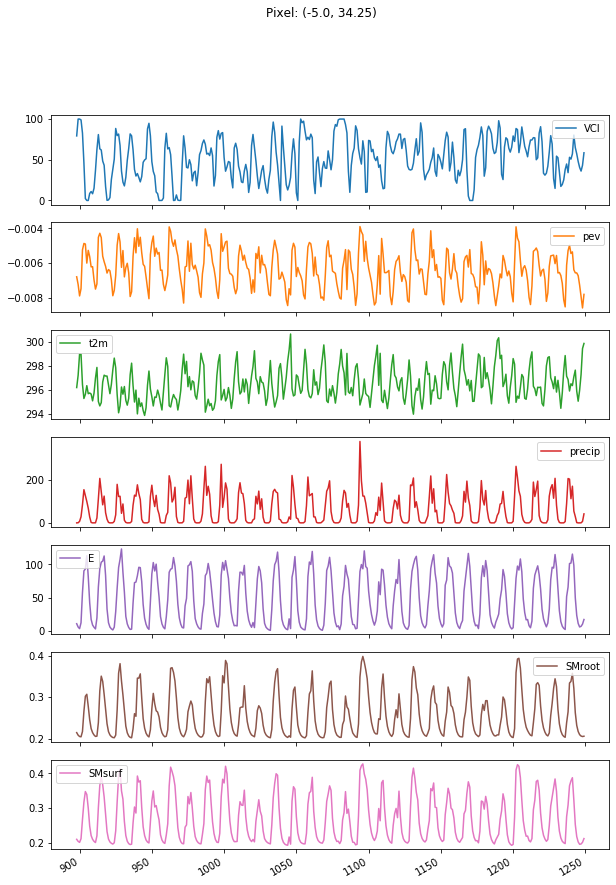

In [14]:
# Plot a single Pixel
pixel_id = 3

df.loc[df['pixel_index'] == pixel_id, [v for v in ds.data_vars]].plot(
    subplots=True, sharex=True, figsize=(10, 15)
)
fig = plt.gcf()
pixel = np.unique(df.pixel.loc[df.pixel_index == pixel_id])[0]
fig.suptitle(f'Pixel: {pixel}')
plt.show()

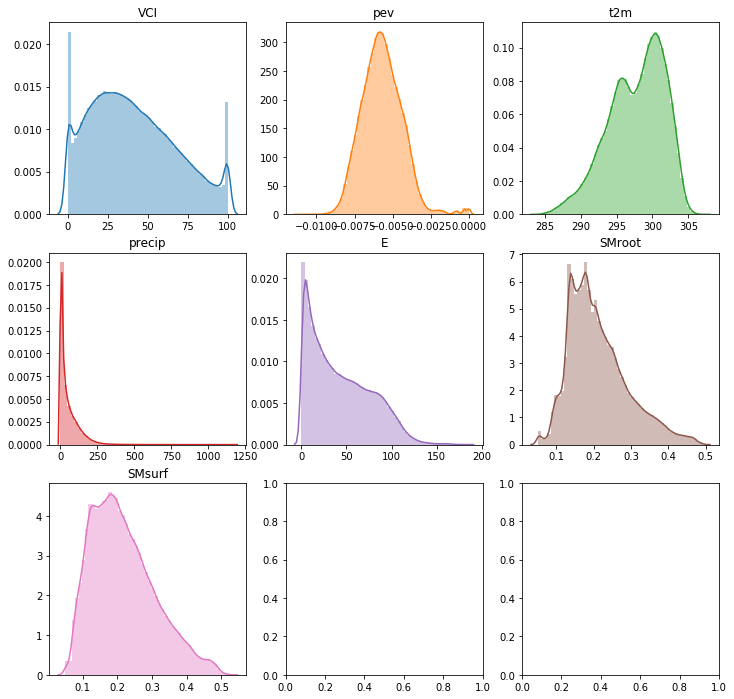

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

xlim_dict = {}
ylim_dict = {}
for i, column in enumerate(df[[v for v in ds.data_vars]].columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(df[column][~df[column].isna()].values, ax=ax, color=colors[i])
    ax.set_title(column)
    xlim_dict[column] = ax.get_xlim()
    ylim_dict[column] = ax.get_ylim()

#### That's great but is there any signal in the other features which can give us some information about the status of the VCI? Let's compare the CONDITIONAL distributions of the variables given a VCI of < 10.

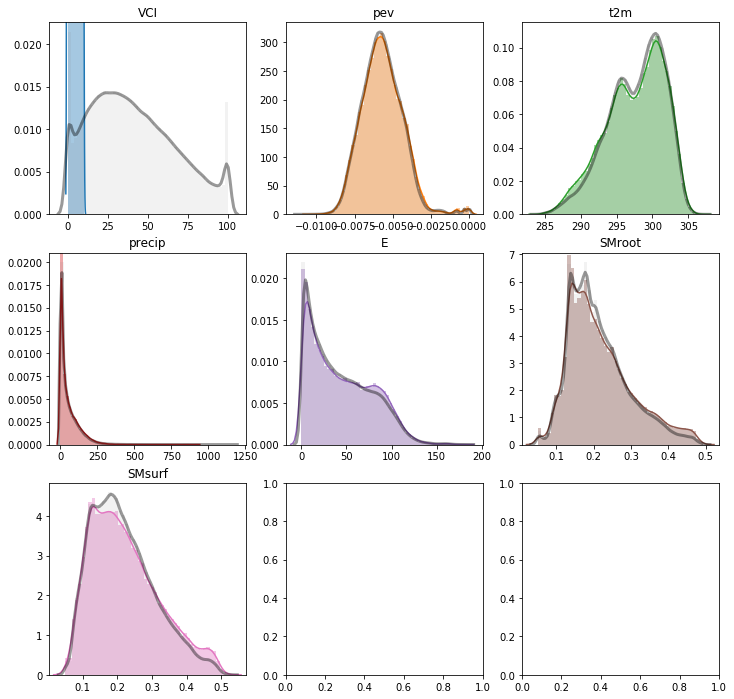

In [134]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

data = df.loc[df.VCI < 10, [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df[column][~df[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])


#### What about being conditional on low rainfall values?

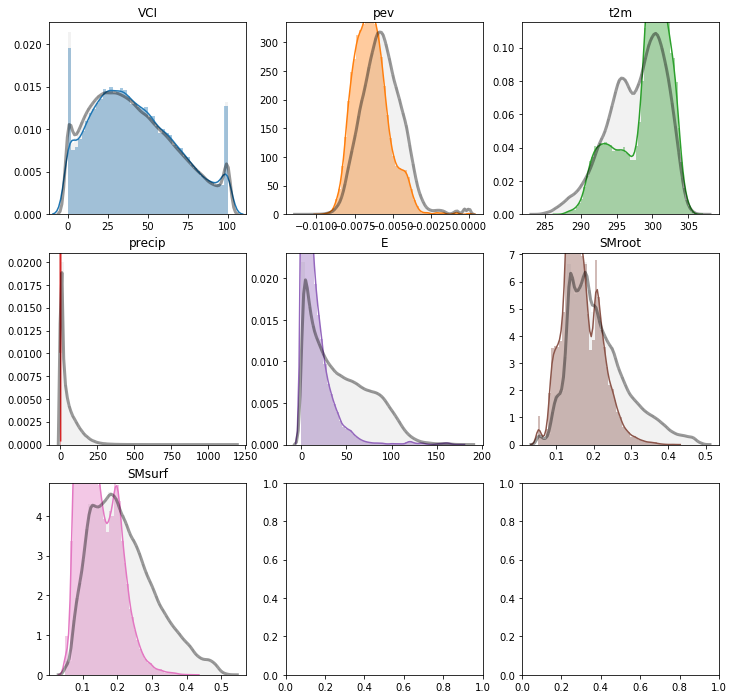

In [33]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

data = df.loc[df.precip < df.precip.quantile(0.1), [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df[column][~df[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])


#### What about the distribution of variables LAGGED by 1 month?
- Select the MONTH BEFORE the VCI was low (< 10)
- Visualise the conditional distribution against the marginal distribution (the grey line)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
colors = sns.color_palette()

data = df.loc[df.VCI < 10, [v for v in ds.data_vars]]

for i, column in enumerate(data.columns):
    ax_ix = np.unravel_index(i, (3, 3))
    ax = axes[ax_ix]
    sns.distplot(data[column][~data[column].isna()].values, ax=ax, color=colors[i])
    sns.distplot(
        df[column][~df[column].isna()].values, ax=ax, color='grey', 
        hist_kws={'alpha':0.1}, kde_kws={"color": "k", "lw": 3, 'alpha':0.4}
    )
    ax.set_title(column)
    ax.set_ylim(ylim_dict[column])
    ax.set_xlim(xlim_dict[column])


In [29]:
data = df.loc[df.VCI < 10, [v for v in ds.data_vars] + ['pixel_index', 'time_index', 'time']]
display(
    data.groupby(['pixel_index']).apply(pd.DataFrame.sort_values, *['time']).set_index('time').head(10)
)
data.groupby(['pixel_index']).apply(pd.DataFrame.sort_values, *['time']).set_index('time').tshift(1, 'M').head(10)
# data.head(2)

,VCI,pev,t2m,precip,E,SMroot,SMsurf,pixel_index,time_index
time,,,,,,,,,
1982-08-31,9.5660,-0.007048,296.468353,2.559121e-08,9.342178,0.210059,0.202564,1,12
1983-05-31,0.0000,-0.006737,297.838440,1.013019e+01,34.648059,0.236992,0.229519,1,21
1983-06-30,0.0000,-0.006481,297.010254,7.639319e-01,14.091694,0.217164,0.206650,1,22
1983-07-31,0.0000,-0.006503,296.324097,5.753846e-02,8.076080,0.209143,0.198387,1,23
1983-08-31,0.0000,-0.006920,297.048981,2.675259e-08,5.753391,0.205021,0.194428,1,24
1983-09-30,3.6725,-0.008024,298.388458,8.740320e-01,4.604958,0.202782,0.192386,1,25
1983-10-31,2.5000,-0.007543,299.242828,1.359298e+01,13.238800,0.203089,0.202848,1,26
1985-09-30,1.9140,-0.006259,294.531616,5.753773e-02,26.690140,0.236423,0.221060,1,47
1985-10-31,7.3600,-0.006917,295.272369,2.588598e-08,16.008666,0.218903,0.204309,1,48


,VCI,pev,t2m,precip,E,SMroot,SMsurf,pixel_index,time_index
time,,,,,,,,,
1982-09-30,9.5660,-0.007048,296.468353,2.559121e-08,9.342178,0.210059,0.202564,1,12
1983-06-30,0.0000,-0.006737,297.838440,1.013019e+01,34.648059,0.236992,0.229519,1,21
1983-07-31,0.0000,-0.006481,297.010254,7.639319e-01,14.091694,0.217164,0.206650,1,22
1983-08-31,0.0000,-0.006503,296.324097,5.753846e-02,8.076080,0.209143,0.198387,1,23
1983-09-30,0.0000,-0.006920,297.048981,2.675259e-08,5.753391,0.205021,0.194428,1,24
1983-10-31,3.6725,-0.008024,298.388458,8.740320e-01,4.604958,0.202782,0.192386,1,25
1983-11-30,2.5000,-0.007543,299.242828,1.359298e+01,13.238800,0.203089,0.202848,1,26
1985-10-31,1.9140,-0.006259,294.531616,5.753773e-02,26.690140,0.236423,0.221060,1,47
1985-11-30,7.3600,-0.006917,295.272369,2.588598e-08,16.008666,0.218903,0.204309,1,48


# X and y data
For time series:
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [139]:
from sklearn.model_selection import TimeSeriesSplit

from tsfresh import extract_features, extract_relevant_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [156]:
df['id'] = df.index
X = df[[v for v in ds.data_vars if v != 'VCI'] + ['pixel_index', 'time_index', 'id']]
y = df.set_index('id')['VCI']  # [['VCI'] + ['pixel_index', 'time_index']]

display(X.head(2))
display(y.head(2))

,pev,t2m,precip,E,SMroot,SMsurf,pixel_index,time_index,id
0,-0.006845,296.760132,2.911272e-08,14.843219,0.215809,0.208432,1,0,0
1,-0.007329,297.860565,1.686568e+00,8.694020,0.208080,0.201334,1,1,1


id
0    39.360001
1    50.802499
Name: VCI, dtype: float64

### play with tsfresh
https://tsfresh.readthedocs.io/en/latest/text/forecasting.html

In [ ]:
filtered_features = extract_relevant_features(X, y, column_id='id', column_sort='time_index')
filtered_features.head(2)

In [ ]:
import pickle

with open(data_dir / 'filtered_features_df.pkl', 'wb') as fp:
    pickle.dump(filtered_feature, fp)

### play with models

In [137]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)